From the DL.AI course

## Training and generation basics
- You add noise to the dataset (noising process, inspired by diffusion in physics, like diffusion of ink within water). From an original image, you go from details to less detailed, to just an outline, to just noise. Model target will be to reverse that process (in a way you are reversing entropy, creating order from noise)
- Target : No noise -> keep it as is, slight noise -> fill in details, outline -> generate details, nothing -> generate outline.
- The model itself will not predict the output image itself, but rather the noise -> we use this noise as an input to a denoiser. So at each training step you add noise, try to predict what was added, and compare to added noise for the Loss.
- Generation : Start from noise and repeat denoising until you are satisfied. It is important to add extra noise between each step else you collapse to an average of the dataset (mostly blobs). This "stabilise" the NN, intuition is that during training since noised image were inserted if you dont keep a semblance of a similar distribution it just collapses

## Sprite generation example

- Code taken from DLAI code, most functions are in utils.diffusion_utilities
- Model is a Unet architecture, with additional layers for :
    - embedding time step (to tell it what time step we are on and thus what level of noise we need)
    - Context embedding : to help control generation (ex : some text to describe what it should generate)

In [1]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
from utils.diffusion_utilities import *

In [2]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image

In [3]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1

In [4]:
# construct model
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

In [5]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [6]:
# load in model weights and set to eval mode
path2model = '/Users/louis.takumi@dataiku.com/Documents/code/perso/image_gen/utils/model_trained.pth'
nn_model.load_state_dict(torch.load(path2model, map_location=device))
nn_model.eval()
print("Loaded in Model")

Loaded in Model


/var/folders/sp/qhkst5xn4dg94f4kktx4gdqr0000gp/T/ipykernel_86619/2073271039.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model.load_state_dict(torch.load(path2mode

In [7]:
# sample using standard algorithm
@torch.no_grad()
def sample_ddpm(n_sample, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t)    # predict noise e_(x_t,t)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate ==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [10]:
path2savefolder = "/Users/louis.takumi@dataiku.com/Documents/code/perso/image_gen/outputs/"

# visualize samples
plt.clf()
samples, intermediate_ddpm = sample_ddpm(32)
animation_ddpm = plot_sample(intermediate_ddpm, 32, 4, path2savefolder, "ani_run", "sprite", save=True)
HTML(animation_ddpm.to_jshtml())

saved gif at /Users/louis.takumi@dataiku.com/Documents/code/perso/image_gen/outputs/ani_run_wNone.gif


<Figure size 640x480 with 0 Axes>

## Sprite Training example

- One version with context : we cannot control output
- One version with context : feed it image captions as text embeddings. In this case very simple context : hero, non-hero, food, items, side-facing (embed at vector of size 5) 

In [17]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = '/Users/louis.takumi@dataiku.com/Documents/code/perso/image_gen/models/'

# training hyperparameters
batch_size = 100
n_epoch = 32
lrate=1e-3

In [18]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1

In [19]:
# construct model
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

In [22]:
# load dataset and construct optimizer
path2sprite = "/Users/louis.takumi@dataiku.com/Documents/code/perso/image_gen/data/sprites_1788_16x16.npy"
path2labels = "/Users/louis.takumi@dataiku.com/Documents/code/perso/image_gen/data/sprite_labels_nc_1788_16x16.npy"
dataset = CustomDataset(path2sprite, path2labels, transform, null_context=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [23]:
# helper function: perturbs an image to a specified noise level
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

### Training with no context

In [24]:
# training without context code

# set into train mode
nn_model.train()

for ep in range(n_epoch):
    print(f'epoch {ep}')
    
    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    
    pbar = tqdm(dataloader, mininterval=2 )
    for x, _ in pbar:   # x: images
        optim.zero_grad()
        x = x.to(device)
        
        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device) 
        x_pert = perturb_input(x, t, noise)
        
        # use network to recover noise
        pred_noise = nn_model(x_pert, t / timesteps)
        
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()
        
        optim.step()

    # save model periodically
    if ep%4==0 or ep == int(n_epoch-1):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save(nn_model.state_dict(), save_dir + f"sprite_model_{ep}.pth")
        print('saved model at ' + save_dir + f"sprite_model_{ep}.pth")

epoch 0


 49%|████████████████████████████████████████████████████████████████████▋                                                                      | 442/894 [05:27<05:38,  1.34it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1089584c0>
Traceback (most recent call last):
  File "/Users/louis.takumi@dataiku.com/.pyenv/versions/3.9.12/envs/py_39_general/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/Users/louis.takumi@dataiku.com/.pyenv/versions/3.9.12/envs/py_39_general/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/louis.takumi@dataiku.com/.pyenv/versions/3.9.12/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/louis.takumi@dataiku.com/.pyenv/versions/3.9.12/lib/python3.9/multiprocessing/popen_fork.py", line 40, i

KeyboardInterrupt: 

### Training with context

In [25]:
# training with context code
# set into train mode
nn_model.train()

for ep in range(n_epoch):
    print(f'epoch {ep}')
    
    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    
    pbar = tqdm(dataloader, mininterval=2 )
    for x, c in pbar:   # x: images  c: context
        optim.zero_grad()
        x = x.to(device)
        c = c.to(x)
        
        # randomly mask out c
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        c = c * context_mask.unsqueeze(-1)
        
        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device) 
        x_pert = perturb_input(x, t, noise)
        
        # use network to recover noise
        pred_noise = nn_model(x_pert, t / timesteps, c=c)
        
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()
        
        optim.step()

    # save model periodically
    if ep%4==0 or ep == int(n_epoch-1):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save(nn_model.state_dict(), save_dir + f"context_model_{ep}.pth")
        print('saved model at ' + save_dir + f"context_model_{ep}.pth")

epoch 0


  0%|▍                                                                                                                                            | 3/894 [00:10<51:41,  3.48s/it]


KeyboardInterrupt: 

In [34]:
# sample with context using standard algorithm
@torch.no_grad()
def sample_ddpm_context(n_sample, context, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t, c=context)    # predict noise e_(x_t,t, ctx)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

def show_images(imgs, nrow=2, figsize=(16, 2)):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=figsize)
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
    plt.show()

/var/folders/sp/qhkst5xn4dg94f4kktx4gdqr0000gp/T/ipykernel_86619/145692434.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model.load_state_dict(torch.load(path2model

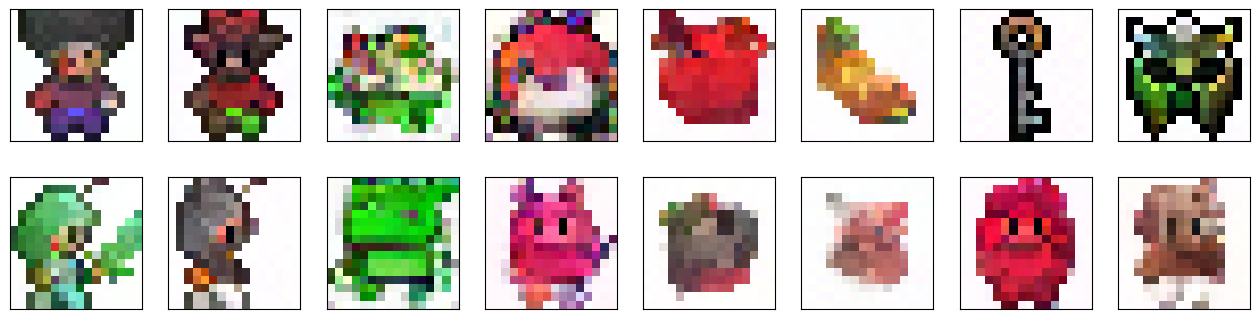

In [39]:
path2model = "/Users/louis.takumi@dataiku.com/Documents/code/perso/image_gen/models/dlai_sprite_context_model_trained.pth"
nn_model.load_state_dict(torch.load(path2model, map_location=device))
nn_model.eval() 

# user defined context
ctx = torch.tensor([
    [1,0,0,0,0],  # hero
    [1,0,0,0,0],  # hero  
    [0,1,0,0,0],  # non-hero
    [0,1,0,0,0],  # non-hero
    [0,0,1,0,0],  # food
    [0,0,1,0,0],  # food
    [0,0,0,1,0],  # item
    [0,0,0,1,0],  # item
    [0,0,0,0,1],  # side-facing
    [0,0,0,0,1],  # side-facing
    [1,1,0,0,0],  # mixes
    [1,0,1,0,0],  # mixes
    [1,0,1,0,1],  # mixes
    [1,0.5,0.5,0,0],  # mixes
    [1,0.5,0.5,0,1],  # mixes
    [1,1,1,1,1],  # mixes
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples, figsize=(16,4))

## Speeding up

- Until now sampling was slow (many timesteps=500, each time step depends on previous one = Markovian)
- DDIM : faster because it skips timesteps. "It predicts a rough idea of the final output then refines it with denoising". Approx 10x faster. Remove randomness from sampling process (more deterministic). Apparently performs a bit worse but is much much quicker. 

In [41]:
# define sampling function for DDIM   
# removes the noise using ddim
def denoise_ddim(x, t, t_prev, pred_noise):
    ab = ab_t[t]
    ab_prev = ab_t[t_prev]
    
    x0_pred = ab_prev.sqrt() / ab.sqrt() * (x - (1 - ab).sqrt() * pred_noise)
    dir_xt = (1 - ab_prev).sqrt() * pred_noise

    return x0_pred + dir_xt

# sample quickly using DDIM
@torch.no_grad()
def sample_ddim(n_sample, n=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    step_size = timesteps // n
    for i in range(timesteps, 0, -step_size):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        eps = nn_model(samples, t)    # predict noise e_(x_t,t)
        samples = denoise_ddim(samples, i, i - step_size, eps)
        intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

# fast sampling algorithm with context
@torch.no_grad()
def sample_ddim_context(n_sample, context, n=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    step_size = timesteps // n
    for i in range(timesteps, 0, -step_size):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        eps = nn_model(samples, t, c=context)    # predict noise e_(x_t,t)
        samples = denoise_ddim(samples, i, i - step_size, eps)
        intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [42]:
# visualize samples, this time only 25 steps
plt.clf()
samples, intermediate = sample_ddim(32, n=25)
animation_ddim = plot_sample(intermediate,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddim.to_jshtml())

<Figure size 640x480 with 0 Axes>

## More general model (needs a gpu)

You can provide text, images, masks as an input. In this case we will use a segmentation mask as input and then inpaint it

- Needs many iterations
- Guidance scale : balance between prompt fidelity and image fidelity (high value = follow prompt but potentially less coherent image)
- Strength : How much noise we add to the part you want to replace (high value = less of original image)
- Negative prompt : reinforce output using words it should not evoque

In [2]:
import torch
from diffusers import StableDiffusionInpaintPipeline

In [4]:
# load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.bfloat16,
    low_cpu_mem_usage=False if torch.cuda.is_available() else True,
).to(device)

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# Set the value of seed manually for reproducibility of the results
seed = 66733
generator = torch.Generator(device).manual_seed(seed)

In [ ]:
prompt = "a realistic green dragon"

In [ ]:
output = sd_pipe(
  image=image,
  mask_image=image_mask,
  prompt=prompt,
  generator=generator,
  num_inference_steps=3,
)